# Chapter 19 Classification Models and Evaluation
# Use Case: Credit Risk - Identifying Bad Credit Risks
# ===========================================

In this example, we aim to predict bad consumer credits, and we develop a classification model for this purpose, driven by loan and debtor attributes. We would use this model to accept or reject a customer’s business.

Dataset: Credit risk https://datahub.io/machine-learning/credit-g
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [113]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

In [114]:
loc = "credit-g.csv"
start_time = time.time()
df = pd.read_csv(loc)
print("It took %s seconds to load the .xlsx file." % (time.time() - start_time))

It took 0.007106781005859375 seconds to load the .xlsx file.


Data Wrangling: As we have shown in previous chapters we need to convert categorical data into one-hot-encodings, clean characters from numeric data columns, carry out type conversions into numeric datatypes... The following cell shows the appropriate data wrangling to get our data into a good shape. 

In [115]:
# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... we force type conversions, then print our resulting df.
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,2,22,1,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,4,40,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,4,23,1,1,1,1,0,...,0,1,0,0,0,1,0,0,0,1


## Problem: Imbalanced dataset

Imbalances in datasets for classification problems are a big issue. We generally need to balance the dataset to contain an equal proportion of the different classes before training (and testing). For the credit use-case, we have two classes {1,0}, meaning that ideally 50% of our samples should be class=1; and 50% class=0. If this is not the case and we have an imbalance (we do), we can balance the data by up-sampling the minority class, or down-sampling the majority class.
Let us first examine the dataset to determine whether it is in balance.

Imbalanced dataset....
0    700
1    300
Name: class, dtype: int64


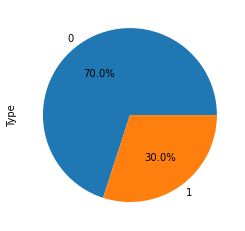

In [116]:

#Pie chart of imbalances wrapped as a func as we will use it a few times..
def pie_of_imbalance(df: pd.DataFrame, class_col: str = 'class'):
    print('Imbalanced dataset....')
    print(df[class_col].value_counts())
    df.groupby(class_col).size().plot(kind='pie', y = 'class', label = "Type",  autopct='%1.1f%%')
    
#run func
pie_of_imbalance(df)

The dataset is not balanced. 70% of samples are class=0; only 30% are class=1. We should bring this into balance before we train our model, or risk introducing dangerous biases into our forecasts.

### NB: Separate training and testing datasets BEFORE balancing the dataset

Before we start up or down-sampling to correct the imbalance, we first we need to create our testing and training datasets. We can then balance the training set. This is to keep the training-set in-sample and the testing-set strictly out-of-sample. This is crucial as our learner must not see any of the test samples until we actually test it for performance. If we fail to separate testing and training data before up samplng, we can suffer data-snooping biases (also called data-leakage), which would invalidate our model.

In [117]:
# Define X and y variables
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

### RandomForest Classifier
We will use the RandomForest classifier to help us test different up and down sampling approaches to deal with the imbalanced dataset. We will be able to see the relative performance of each balancing approach on our problem.

First let us run the classifier on the imbalanced data and examine the F1 score that results when we test the model. (It is a very poor result).

Get the sklearn packages we will need for our clasification problem

In [132]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# CLassifiers
from sklearn.ensemble import RandomForestClassifier


# metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

We can wrap training for the Random Forest classifier, and the printing of performance metrics in a function, as we will be running this more than once.

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.7986, test:  0.7800
Precision train: 0.7742, test:  0.7722
Recall train: 0.9979, test:  0.9909
F1 train: 0.5284, test:  0.3400


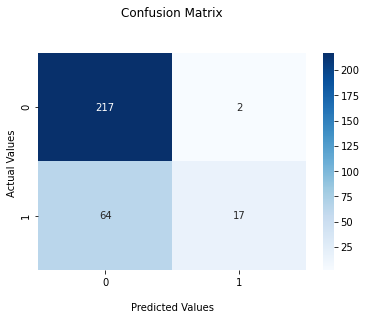

In [155]:
# Declare a function to wrap training of a classifier and printing of performance data
def run_rf_classification_models(X_train: pd.DataFrame, X_test: pd.DataFrame, 
                            y_train: pd.DataFrame, y_test: pd.DataFrame) -> list:
    
    # Scale and transform the data for training
    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_train) # scale both sets:
    X_test = sclr.fit_transform(X_test)

    # classifier train
    rf = RandomForestClassifier(max_depth=5,random_state=0)
    rf.fit(X_train,y_train)
    y_train_hat =rf.predict(X_train)
    y_test_hat = rf.predict(X_test)

    # Print score
    print(type(rf))        
    print(f"Accuracy train: {rf.score(X_train,y_train):.4f}, test: ",
      f"{rf.score(X_test,y_test):.4f}")
    print(f"Precision train: {precision_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{precision_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{recall_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
      f"{f1_score(y_test,y_test_hat, average=None)[1]:.4f}")
    #print(f1_score(y_test, y_test_hat, average=None))


    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

#run RF classifier function
run_rf_classification_models(X_train, X_test, y_train, y_test)

## Test the performance of different up, and down sampling approaches

### 1) Upsampling using resampling

First we test up-sampling using sklearn's resample, and examine how well it does using the RandomForest classifier. Resampling can up-sample by simply randomly selecting and copying existing observations of the minority class. We can balance the classes in this way.

In [134]:
from sklearn.utils import resample

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Create up-sampled data set for minority class
# note that n_samples= the number of samples the imbalance represents.
X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=(X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0]),
                                        random_state=None)

#Combine train with upsampled
X_upsampled = X_train.append(X_upsampled)
y_upsampled = y_train.append(y_upsampled)

Let us check everything is in balance now

Imbalanced dataset....
1    486
0    486
Name: class, dtype: int64


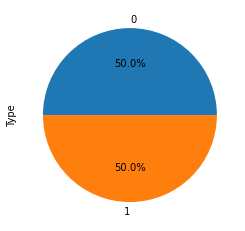

In [135]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled, y_upsampled], axis=1)
pie_of_imbalance(temp)

Dataset is perfectly in balance...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8292, test:  0.7233
Precision train: 0.8704, test:  0.8659
Recall train: 0.7737, test:  0.7243
F1 train: 0.8382, test:  0.5990


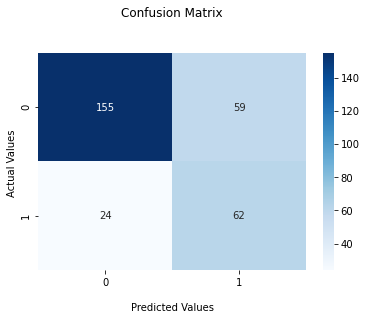

In [136]:
#Run our function....
all_models = run_rf_classification_models(X_upsampled, X_test, y_upsampled, y_test)

The F1 score on the test data has increased markedly.

### 2) Up-sampling using a synthetic over sampling approach called SMOTE

Add the libraries we will need... and generate the synthetic data to balance our classes using SMOTE.

In [137]:
from imblearn.over_sampling import SMOTE

#How many samples do we need to balance?
idx = np.random.choice(X_train.shape[0], size=X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0], replace=False)

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

Before we use the up-sampled dataset to train our classifier, let us first examine the distribution of the synthetic datapoints that SMOTE creates

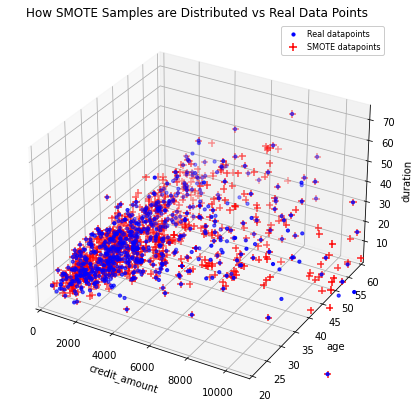

In [149]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['credit_amount'],X_train['age'], X_train['duration'], marker="o", s=10, c='blue', label='Real datapoints')
ax.scatter(X_upsampled_smote['credit_amount'],X_upsampled_smote['age'], X_upsampled_smote['duration'], marker="+", s=50, c='red', label='SMOTE datapoints')

# set axes range
plt.xlim(0, 11000)
plt.ylim(20, 60)

ax.set_xlabel('credit_amount')
ax.set_ylabel('age')
ax.set_zlabel('duration')

plt.title('How SMOTE Samples are Distributed vs Real Data Points')
plt.legend(loc=1,framealpha=1, fontsize=8)
plt.show()

The synthetic datapoints look realistic at a glance.

Imbalanced dataset....
1    486
0    486
Name: class, dtype: int64


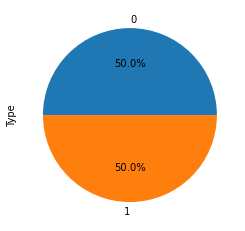

In [150]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled_smote, y_upsampled_smote], axis=1)
pie_of_imbalance(temp)

After up-sampling using SMOTE's synthetic data, the dataset is perfectly in balance...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8765, test:  0.7600
Precision train: 0.9013, test:  0.8380
Recall train: 0.8457, test:  0.7772
F1 train: 0.8802, test:  0.6842


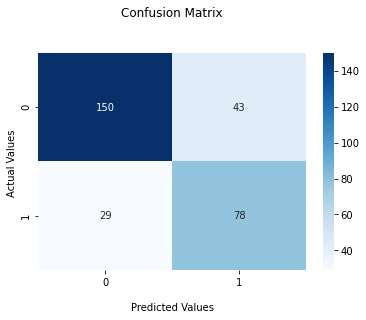

In [151]:
#Run our function....
all_models = run_rf_classification_models(X_upsampled_smote, X_test, y_upsampled_smote, y_test)

### 3. Down-sampling

Now we can test down-sampling, which is simply removing samples from the majority class. 

In [156]:
from imblearn.under_sampling import RandomUnderSampler 

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Randomly downsample rows in the majority class
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

Imbalanced dataset....
1    202
0    202
Name: class, dtype: int64


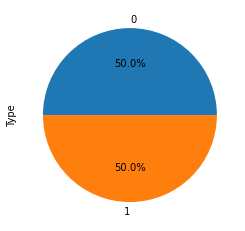

In [157]:
#get pie of the current imbalance
temp = pd.concat([X_downsampled, y_downsampled], axis=1)
pie_of_imbalance(temp)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8391, test:  0.6633
Precision train: 0.8586, test:  0.8301
Recall train: 0.8119, test:  0.6287
F1 train: 0.8434, test:  0.5878


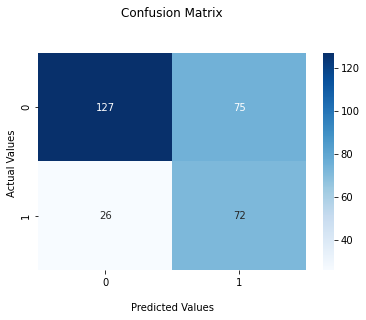

In [158]:
#Run our function....
all_models = run_rf_classification_models(X_downsampled, X_test, y_downsampled, y_test)

As we can see, all up and down sampling approaches have outperformed the F1 Score on the imbalanced data. The most impressive performance in this case is from up-sampling using SMOTE synthetic data.